# Stroke Classfier
> - Gabrile Serafini
> - Marco Sousa-Poza

This Notebook discribes the computations made to find an optimal stroke classifier based on real healthcare data.

## Exploring the Data
In the following the data will be read and prepared for further use.

In [2]:
# All the necessary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
# Reading the data into a data frame
df_health = pd.read_csv('data/healthcare-dataset-stroke-data.csv')
df_health.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


We see that the data contains some NaN values. If there are not too many we can delete them.

In [4]:
print("The number of NaN values for each column is:")
print(df_health.isna().sum())
print("There are {} rows in this df.".format(df_health.shape[0]))

The number of NaN values for each column is:
id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64
There are 5110 rows in this df.


Since there are not that many NaN values we can drop them. We will also drop the id as it is not important.

In [5]:
df_health.dropna(axis=1, inplace=True)
df_health.drop('id', axis=1, inplace=True)

Next we change the nominal attributes to numbers. This is important for the more mathematical models we are going to use later on.

In [6]:
obj_df = df_health.select_dtypes(include=['object'])
for col in obj_df.columns:
    print(obj_df[col].value_counts())

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64
Yes    3353
No     1757
Name: ever_married, dtype: int64
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64
Urban    2596
Rural    2514
Name: Residence_type, dtype: int64
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64


In [7]:

# We again find some hidden NaN values. We can delete those:
df_health.drop(df_health[df_health['gender'] == 'Other'].index, inplace=True)
#NOTE: For now we simpy drop unknows values. Idea is to maybe infere these values
df_health.drop(df_health[df_health['smoking_status'] == 'Unknown'].index, inplace=True)

gender_dict = {'Female':1, 'Male':0}
married_dict = {'Yes':1, 'No':0}
worktype_dict = {'Private':4, 'Self-employed':3, 'children':2, 'Govt_job':1, 'Never_worked':0}
residence_dict = {'Urban':1, 'Rural':0}
smoke_dict = {'never smoked':2,'formerly smoked':1,'smokes':0}
health_numerical = df_health.replace(
    {
        'gender':gender_dict,
        'ever_married':married_dict,
        'work_type':worktype_dict,
        'Residence_type':residence_dict,
        'smoking_status':smoke_dict
    }
).values

In [8]:
y = df_health['stroke'].values
columns = df_health.columns[:-1]
target = df_health.columns[-1]
X_n = health_numerical[:, :-1]
X_v = df_health.values[:, :-1]

## Data Vizualisation



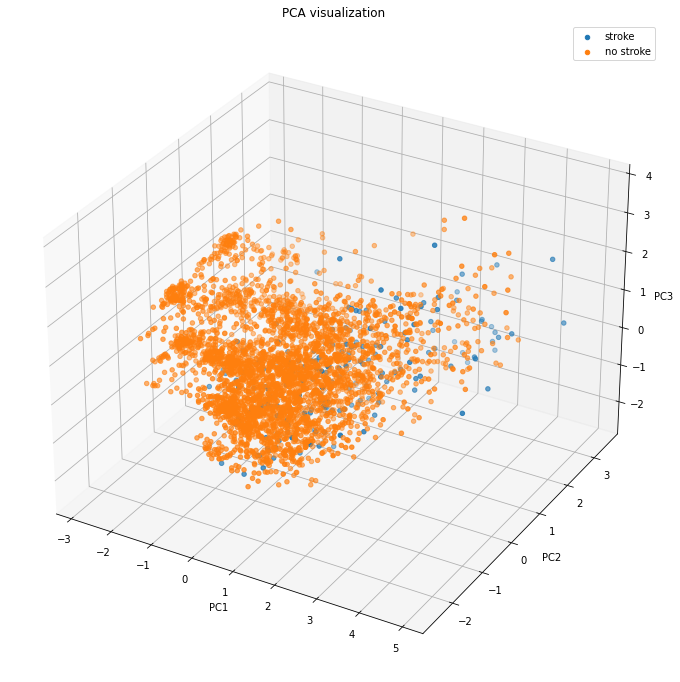

In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
stc = StandardScaler()
pca = PCA()
p = Pipeline([('scaler', stc), ('pca', pca)])
health_pca = p.fit_transform(X_n)

# Plot PCA
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

ax.scatter(health_pca[y==1][:,0], health_pca[y==1][:,1], health_pca[y==1][:,2], label='stroke')
ax.scatter(health_pca[y==0][:,0], health_pca[y==0][:,1], health_pca[y==0][:,2], label='no stroke')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend()
ax.set_title('PCA visualization')

plt.show()

We can see that the data is not well separated by the PCs. This is a indicator that the data will probably not be that well separated with a linear model. This is something we need to keep in mind when choosing hyperparameters for some of our classifiers.

## Classification
### Random Forest

In [15]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from itertools import product

min_splits = [n for n in range(2, 60, 2)]
max_depth = [n for n in range(10,120,5)]
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=20)

avg_scores = []
for h1, h2 in product(min_splits, max_depth):
    model = DecisionTreeClassifier(
        criterion='gini', 
        max_depth=h2, 
        min_samples_split=h1
    )
    scores = cross_val_score(model, X_n, y, scoring='recall', cv=cv, n_jobs=-1)
    avg_scores.append(((h1, h2), np.mean(scores)))

avg_scores = sorted(avg_scores, key=lambda x: x[1], reverse=True)
print('The 10 best hyper-parameters are:')
for i in range(10):
    param, score = avg_scores[i] 
    print('-{} place: parameters: splits={} and depth={}, score={}'.format(i+1, *param, score))

The 10 best hyper-parameters are:
-1 place: parameters: splits=2 and depth=50, score=0.1644939024390244
-2 place: parameters: splits=2 and depth=90, score=0.16217682926829266
-3 place: parameters: splits=2 and depth=75, score=0.16184756097560973
-4 place: parameters: splits=2 and depth=70, score=0.16166463414634144
-5 place: parameters: splits=2 and depth=55, score=0.16165243902439022
-6 place: parameters: splits=2 and depth=80, score=0.16135975609756098
-7 place: parameters: splits=2 and depth=30, score=0.15840243902439022
-8 place: parameters: splits=2 and depth=85, score=0.15804268292682924
-9 place: parameters: splits=2 and depth=60, score=0.1557621951219512
-10 place: parameters: splits=2 and depth=40, score=0.1555243902439024


In [12]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=70, min_samples_split=2)
clf.fit(X_n, y)

DecisionTreeClassifier(criterion='entropy', max_depth=70)

Vizualize the tree to gain some imformation:

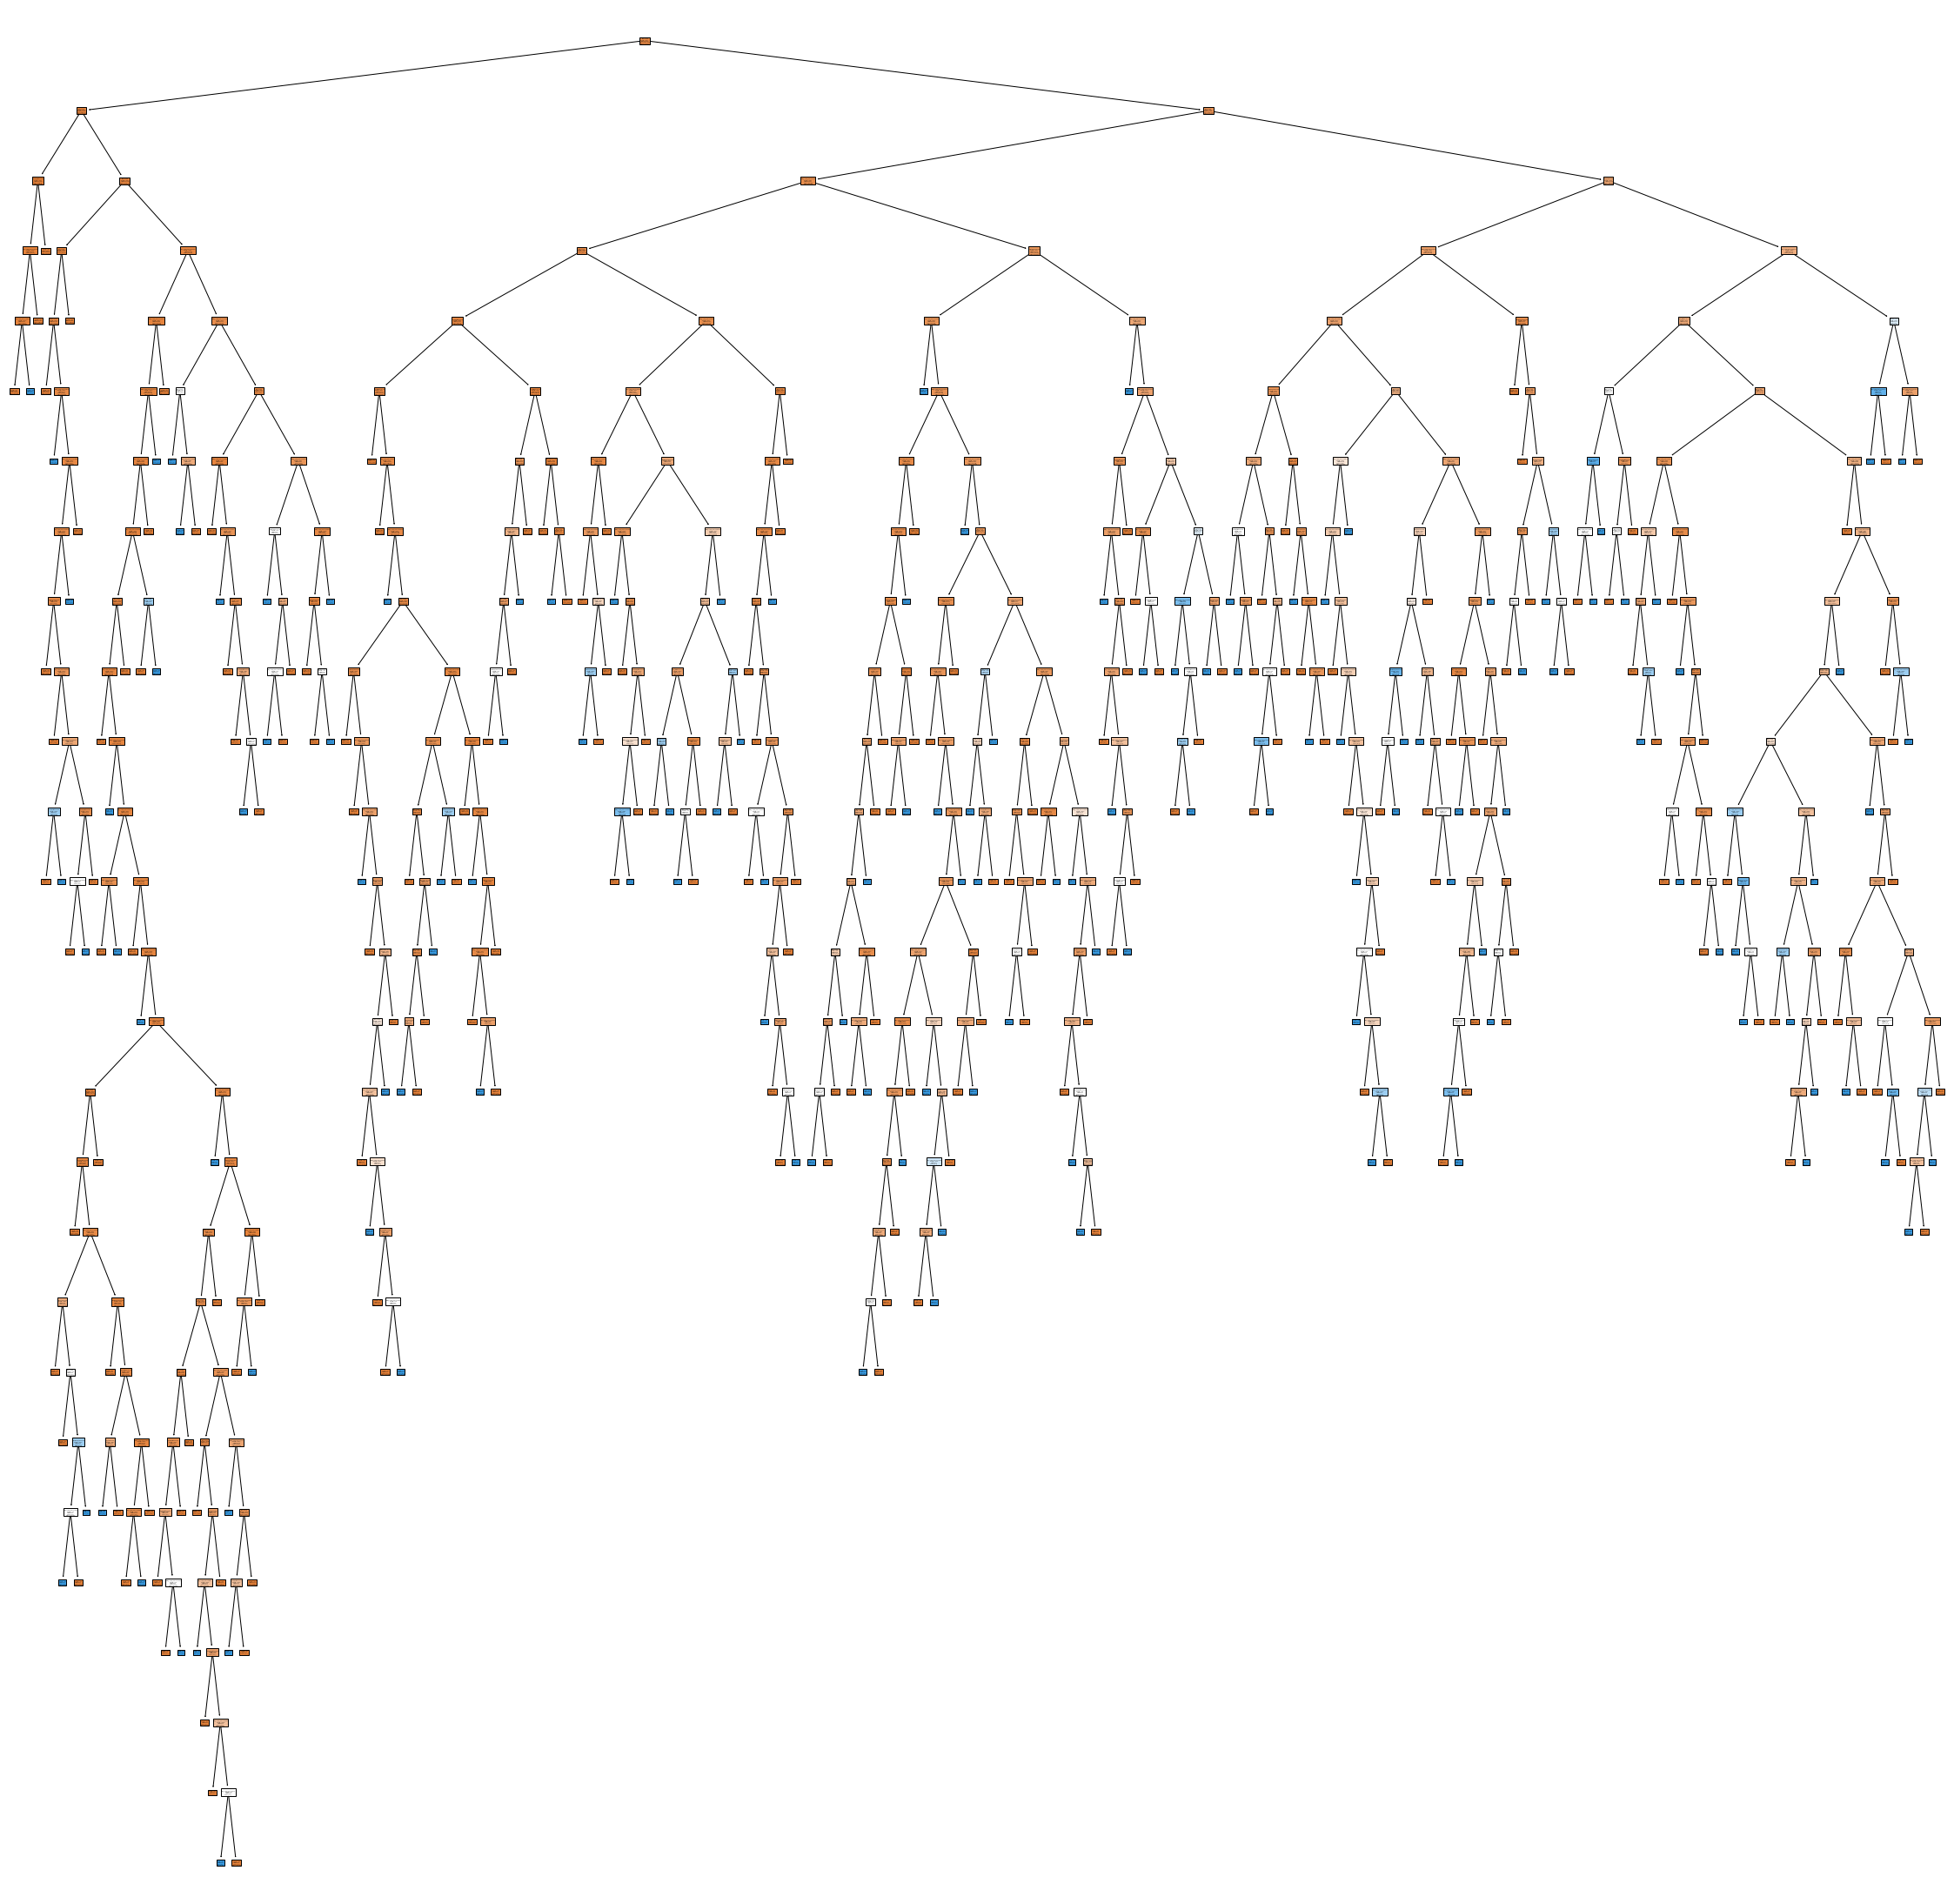

In [13]:
fig = plt.figure(figsize=(40,40))
_ = plot_tree(clf, 
             feature_names=columns,  
             class_names=['no stroke', 'stroke'],
             filled=True)
plt.show()

#### Conclusion
This classifier is not workin all to well. TODO explain

In [20]:
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from itertools import product

model = ComplementNB()
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=40)
scores = cross_val_score(model, X_n, y, scoring='recall', cv=cv, n_jobs=4)
print('The recall score of the naive bayes classifier is {}'.format(np.mean(scores)))

The recall score of the naive bayes classifier is 0.6045213414634145
The recall score of the naive bayes classifier is 0.6030715287517531
